# Modell-Auswahl

Bei Verfahren, die einen oder mehrere Parameter zur Auswahl lassen, gibt es nicht immer eine natürliche Wahl der Parameter - meist muss man einfach ausprobieren, was für den konkret betrachteten Datensatz am besten funktioniert.

Bei vielen konkreten Datensätzen sind merere Modelle denkbar und es gibt nicht immer eine natürliche Wahl des voraussichtlich besten Modells - meist lohnt sich auch hier ein vergleich verschiedener Ansätze.

Um zu bewerten, welches Modell 'besser' ist als andere, gibt es verschiedene Möglichkeiten. Wir haben bereits gesehen, dass Overfitting ein Problem sein kann, sodass der bloße Vergleich der Anzahl korrekt klassifizierter Samples nicht zwangsläufig das am besten verallgemeinerte Modell aussucht.

## Training, Test und neue Daten

Die 'klassische Situation' beim maschinellen Lernen ist, dass man zur Zeit der Entwicklung eines ML-Systems Zugang zu Daten hat (den Trainingsdaten), die potentiell bereits gelabelt sind (also bei denen die gewünschte Ausgabe des ML-Systems bereits Teil der Daten ist).
Danach (nach der Trainings-Zeit) soll das System auf neu eintreffenden Daten funktionieren - diese sind nicht gelabelt.

Da man bei ungelabelten Daten nicht beurteilen kann, wie gut das ML-System gearbeitet hat, verwendet man zur Beurteilung einen Teil der gelabelten Trainingsdaten - und nennt dies die Testdaten. Von späteren 'echten' Daten unterscheiden sich die Testdaten dadurch, dass sie gelabelt sind.

Wir haben dazu bereits `train_test_split` kennen gelernt.

![Hyperparameter Tuning](images/grid_search_workflow.png "Splitten der Daten zur Bewertung von Modellen")

(Grafik aus der Scikit-Learn-Dokumentation)

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.datasets import load_iris
x, y = load_iris(return_X_y=True)

### Training, Validation und Test

Wenn man bei der Entwicklung eines ML-Systems 200 verschiedene Varianten vergleicht, indem man ihre Performance auf dem Test-Datensatz nach dem fitten auf dem Trainings-Datensatz analysiert, so führt das unweigerlich zu einem impliziten Fit auf den Test-Datensatz und damit zu einem ML-System, welches schlecht generalisiert. Man spricht davon, dass der Test-Datensatz **leakt** (Information Leakage, ein Informationsleck).

Damit man einerseits Varianten vergleichen kann, andererseits aber auch einen Test-Datensatz behalten möchte, um beurteilen zu können, wie gut das System arbeitet, teilt man den Test- bzw. den Trainingsdatensatz weiter auf.

Ein typisches Setting ist, in Wettbewerben die Target-Variable im Test-Datensatz zurück zu halten. Um trotzdem vor Abschluss des Wettbewerbs verschiedene Modelle vergleichen zu können, kann man einen Teil des Trainings-Datensatzes als Validation-Datensatz abtrennen und nicht für das Training verwenden.

### k-fold Cross Validation

Bei der Auswahl eines Test- bzw. eines Validation-Datensatzes gibt es zwei grundlegende Probleme: 

* man könnte Pech haben und sehr wenig repräsentative Teil-Datensätze erwischen
* weniger Daten zum Training werden zu schlechteren Ergebnissen führen.

Bei der **k-fachen Kreuzvalidierung** versucht man diese beiden Probleme zu lösen, indem man mehrfach, nämlich k mal, das ML-System laufen lässt, jeweils mit einer anderen Aufteilung in Trainings- und Testdaten. Dazu teilt man den Trainings-Datensatz in k gleiche Teile ein (genannt *folds*), und verwendet bei jedem der k Durchläufe den k-ten Teil als Test (und lässt diesem beim Training weg).

Damit optimiert man auf Modelle, die gut auf unbekannte Daten verallgemeinern.

In [2]:
from sklearn.model_selection import KFold

from sklearn.datasets import load_iris
x, y = load_iris(return_X_y=True)

cv = KFold(n_splits=3, shuffle=True, random_state=23)

for train_i, test_i in cv.split(x):
    print(test_i)
    test_x = x[test_i]
    test_y = y[test_i]
    print("mean of class label:", np.mean(y[test_i]))

[  2   3   5   7   9  10  16  17  18  19  20  24  28  30  34  44  45  46
  47  51  52  54  59  63  64  67  69  73  75  81  87  93  95  99 100 102
 106 113 115 120 122 125 126 131 133 135 137 139 140 146]
mean of class label: 0.94
[  1   4   8  11  23  26  27  29  33  37  42  50  53  55  61  62  68  70
  71  72  76  77  80  82  84  85  88  89  92  97 101 104 105 107 109 110
 111 112 114 117 119 121 127 128 130 132 134 136 142 148]
mean of class label: 1.18
[  0   6  12  13  14  15  21  22  25  31  32  35  36  38  39  40  41  43
  48  49  56  57  58  60  65  66  74  78  79  83  86  90  91  94  96  98
 103 108 116 118 123 124 129 138 141 143 144 145 147 149]
mean of class label: 0.88


### Stratified k-fold Cross Validation

Wenn man im supervised learning Setting arbeitet, also gelabelte Trainingsdaten hat, dann kann es sinnvoll sein, bei der k-fachen Kreuzvalidierung in den einzelnen 'folds' jeweils repräsentative Anteile aller Klassen zu haben. Das nennt man **stratifizierte k-fache Kreuzvalidierung**.

In [3]:
from sklearn.model_selection import StratifiedKFold

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

print("The following %d numbers should be quite similar:"
      % cv.get_n_splits())
for train_i, test_i in cv.split(x, y):
    print("mean of class label:", np.mean(y[test_i]))

The following 3 numbers should be quite similar:
mean of class label: 0.98
mean of class label: 1.0
mean of class label: 1.02


### Zeitreihen-sensible Kreuzvalidierung

Die zuvor diskutierten Kreuzvalidierungsverfahren gehen davon aus, dass die Daten unabhängig und identisch verteilt sind, dass also insbesondere jedes einzelne Sample gleich viel 'wert' ist. Wenn die Daten aber über einen Zeitraum hinweg erhoben werden, ist diese Annahme meist nicht korrekt. In vielen Fällen kann es sinnvoll sein, davon auszugehen, dass vergangene Daten einen Einfluss auf Daten in der Zukunft haben.

Der naive Ansatz wäre nun, die erste Hälfte (zeitlich gesehen) der Daten zum Training zu verwenden, die zweite (spätere) Hälfte dann als Test.

```{admonition} Beispiel
Ein Modell zur Vorhersage der mittleren Temperatur der Erdoberfläche aus den Konzentrationen von Treibhausgasen in der Atmosphäre wird an einem Zeitraum 1800 bis 2000 gefittet, und dann zur 'Vorhersage' für die Jahre 2000--2022 genutzt, damit wir das Modell mit anderen vergleichen können. 
```

Mit Scikit-learn kann man `TimeSeriesSplit` verwenden, dessen Syntax und Semantik wie `KFold` bzw. `StratifiedKFold` ist, lediglich die Anzahl an Samples in den einzelnen Schritten ist anders. Zusätzlich gibt es noch den ganzzahligen Parameter `gap`,
der bestimmt, wie viel Samples aus jedem Trainingsdatensatz am Ende ausgelassen werden sollen. Damit wird verhindert, dass bei stetigen Daten die Datenpunkte am Ende zu viel 'wissen' über die darauf folgenden Datenpunkte im Testdatensatz.

### Visualisierung der Kreuzvalidierungsstrategien

Auszug [aus der Scikit-learn-Dokumentation](https://scikit-learn.org/stable/auto_examples/model_selection/plot_cv_indices.html#visualizing-cross-validation-behavior-in-scikit-learn):

![KFold](images/sphx_glr_plot_cv_indices_006.png)

![StratifiedKFold](images/sphx_glr_plot_cv_indices_009.png)

![TimeSeriesSplit](images/sphx_glr_plot_cv_indices_013.png)


## Bewertung der Modellperformance

Wir haben bereits drei wesentliche Ansätze zur Bewertung der Güte von Modellen gesehen:

* Bei gleicher Zuordnung der Label, also wenn zu Klassen $1,2,..$ mit ursprünglichem Label $A,B,..$ das Modell ebenfalls den Klassen die Label $A,B,..$ gibt, und nicht etwa eine Permutation davon, dann haben wir verglichen, wie oft das Modell richtig/falsch liegt. Das geht mit `sklearn.metrics.accuracy_score`.
* Bei einer Permutation der Label (so wie wir es bei k-Means gesehen haben) können wir berechnen, welche Permutation am meisten 'richtige' Treffer für das Modell bedeutet, und damit arbeiten (wir stellen uns vor, die Permutation der Label damit rückgängig zu machen).
* Bei einer Permutation der Label können wir eine permutationsinvariante Bewertung verwenden, etwa die `normalized_mutual_info_score` $NMI$. Zur Erinnerung:

$$
NMI(U, V) = \dfrac{ H(U,V) }{ \texttt{mean}( H(U), H(V)) }
$$

### Bewertung von Clustering

Im supervised learning können wir bewerten, ob die Cluster jeweils nur Samples einer Klasse enthalten bzw. wie stark das Clustering davon abweicht (Homogenität) und wir können bewerten, ob alle Samples einer Klasse auch nur zu einem Cluster zugeordnet sind:

In [4]:
from sklearn.cluster import KMeans

y_pred = KMeans().fit(x).predict(x)

from sklearn.metrics import homogeneity_score,\
                            completeness_score

print("Homogeneity:", homogeneity_score(y, y_pred))
print("Completeness:", completeness_score(y, y_pred))

Homogeneity: 0.9255604738929599
Completeness: 0.5106133716599914


Warum ist die Completeness im Beispiel so schlecht? Das liegt daran, dass wir KMeans nicht mit einer Anzahl an Clustern initialisiert haben, und damit eine höhere Zahl als 3 zustande kommt:

In [5]:
print("Anzahl Cluster:", np.max(y_pred)+1)
print("Anzahl Klassen:", np.max(y)+1)

Anzahl Cluster: 8
Anzahl Klassen: 3


Wir wiederholen das nun mit $3$ Clustern und beobachten, wie sich die Vollständigkeit erhöht, aber die Homogenität sinkt:

In [6]:
y_pred = KMeans(3).fit(x).predict(x)
assert np.max(y) == np.max(y_pred)

print("Homogeneity:", homogeneity_score(y, y_pred))
print("Completeness:", completeness_score(y, y_pred))

Homogeneity: 0.7514854021988339
Completeness: 0.7649861514489816


Das harmonische (potentiell gewichtete) Mittel aus Homogenität und Vollständigkeit heißt auch **V-Maß**, `v_measure_score`, und man kann zeigen, dass dieses Maß äquivalent zur normalisierten gemeinsamen Information $NMI$ ist.

Eine andere Zusammenfassung der Klassifikationsgüte beim Clustering:

In [7]:
from sklearn.metrics import classification_report
print(classification_report(y, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        50
           1       0.00      0.00      0.00        50
           2       0.95      0.72      0.82        50

    accuracy                           0.24       150
   macro avg       0.32      0.24      0.27       150
weighted avg       0.32      0.24      0.27       150



### Bewertung einer Regression

Zur Bewertung einer Regression verwendet man den $R^2$-Wert `r2_score`.

Im Gegensatz zur Intutition hinter dem Namen kann der $R^2$-Wert durchaus negativ werden, die Formel ist

$$
R^2 = 1 - \dfrac{\sum_i {\left(y_i - f(x_i, \beta)\right)}^2}{\sum_i {\left(y_i - \texttt{mean}(y)\right)}^2}
$$

Wenn das Modell perfekt die Daten vorhersagt, so ist der Zähler, die Summe der Residuenquadrate, $0$ und damit $R^2 = 1$.

Das konstante Modell, welches stets $f(x_i, \beta) = \texttt{mean}(y)$ ist (also der beste Fit unter allen konstanten Modellen) hat $R^2 = 0$. Modelle, die schlechter performen (z.B. andere konstante Modelle) haben negative $R^2$-Werte.

## Hyperparametersuche

Wenn man sich überlegt hat, welche Schätzer / Verfahren man gerne verwenden möchte, welche Kreuzvalidierung man verwenden möchte und welche Bewertungsfunktion geeignet ist, benötigt man noch eine Suchstrategie.

Eine Möglichkeit wäre, zufällig zwei verschiedene Hyperparameter zu verwenden und für diese zu vergleichen, welcher besser performt (im Sinne der gewählten Bewertungsfunktion). Danach könnte man in der Nähe des besseren Parameters zufällig zwei neue wählen und das Verfahren wiederholen, usw.

```{admonition} Beispiel
Hyperparameter sind etwa die Anzahl Cluster bei k-Means (das k),
oder auch die Anzahl an zu behaltenden Hauptkomponenten bei PCA,
oder die Regularisierungskonstante $\alpha$ bei einer linearen Regression,
oder der Regularisierungsparameter $C$ bei einer SVM,
oder die Parameter eines verwendeten Kernels,
wie z.B. der Grad bei einem polynomialen Kernel.
```

### Gittersuche

Wenn wir mehrere Parameter zugleich optimieren wollen, wäre eine Möglichkeit, den einen Parameter festzuhalten, den anderen zu optimieren, und danach den zunächst festgehaltenen zu optimieren. Es ist aber klar, dass man im 'loss landscape' damit kein Optimum erreicht. Besser ist es, alle möglichen Kombinationen der beiden Parameter abzusuchen.

best parameters: {'alpha': 0.03125, 'gamma': 0.10526315789473684}
r2 = 0.3635330526063229


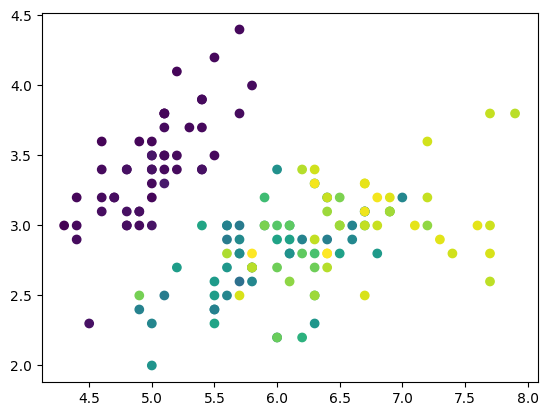

In [8]:
from sklearn.model_selection import GridSearchCV

from sklearn.kernel_ridge import KernelRidge
clf = KernelRidge(kernel='rbf')

param_grid = {
    "gamma": np.linspace(0, 1, num=20),
    "alpha": np.power(2, np.arange(-6, 5, dtype=float)),
}

grid_search = GridSearchCV(clf, param_grid=param_grid, scoring='r2')
grid_search.fit(x, y)

print("best parameters:", grid_search.best_params_)
print("r2 =", grid_search.best_score_)

est = grid_search.best_estimator_

fig, ax = plt.subplots()
ax.scatter(x[:,0], x[:,1], c=est.predict(x))
plt.show()

### Randomisierte Suche

Man kann auch Paare von Parametern untersuchen, die zufällig aus einer gegebenen Verteilung gesampelt werden.

best parameters: {'alpha': 0.045126326783279366, 'gamma': 0.09155596484422546}
r2 = 0.3624497597525492


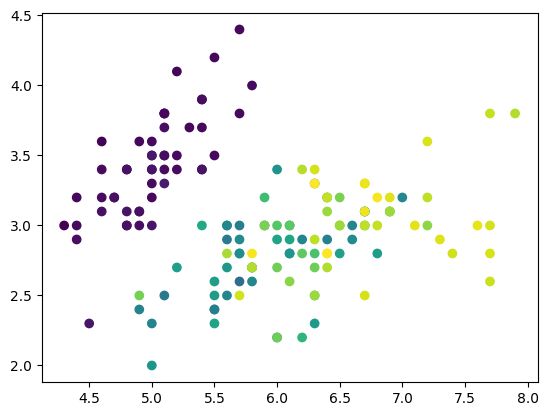

In [9]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.utils.fixes import loguniform
from scipy.stats import uniform

param_dist = {
    "gamma": uniform(0, 1),
    "alpha": loguniform(1e-3, 1e0)
}

random_search = RandomizedSearchCV(
    clf,
    param_distributions=param_dist,
    n_iter=40
)

random_search.fit(x, y)

print("best parameters:", random_search.best_params_)
print("r2 =", random_search.best_score_)

est = random_search.best_estimator_

fig, ax = plt.subplots()
ax.scatter(x[:,0], x[:,1], c=est.predict(x))
plt.show()

## Anwendungsbeispiel: Fashion MNIST

Je drei Zeilen bilden eine Klasse (T-Shirts, Hosen, etc.). Die Daten kommen von [Zalando Research](https://github.com/zalandoresearch/fashion-mnist). Der klassische 'handwritten digits' MNIST Datensatz hat das Problem, dass es etwas zu einfach ist, diesen korrekt zu klassifizieren. Fashion-MNIST ist als drop-in Ersatz gedacht, anstelle von MNIST als Benchmark für ML-Algorithmen zu dienen.

![Fashion MNIST](https://github.com/zalandoresearch/fashion-mnist/raw/master/doc/img/fashion-mnist-sprite.png)

In [10]:
from itertools import product
from urllib.request import urlretrieve
import gzip
import numpy as np

filepattern = "%s-%s-ubyte.gz"
baseurl = "http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/"

def load_mnist_labels(filename):
    with gzip.open(filename, 'rb') as file:
        return np.frombuffer(file.read(),
                             dtype=np.uint8,
                             offset=8)
    
def load_mnist_images(filename):
    with gzip.open(filename, 'rb') as file:
        return np.frombuffer(file.read(),
                             dtype=np.uint8,
                             offset=16).reshape(-1, 784)

def load_mnist(kind='train'):
    labelfilename = filepattern % (kind, "labels-idx1")
    imagefilename = filepattern % (kind, "images-idx3")
    urlretrieve(baseurl + labelfilename, "./" + labelfilename)
    urlretrieve(baseurl + imagefilename, "./" + imagefilename)
    labels = load_mnist_labels(labelfilename)
    images = load_mnist_images(imagefilename)
    return images, labels

In [11]:
x_train, y_train = load_mnist(kind='train')
x_test, y_test = load_mnist(kind='t10k')

Wir müssen die Dimensionalität reduzieren, sonst dauert das Training zu lange:

In [12]:
from sklearn.decomposition import PCA
pca = PCA(40).fit(x_train)
x_train_pc = pca.transform(x_train)
x_test_pc = pca.transform(x_test)

Wir werfen einen ersten Blick auf das Ergebnis einer Support Vector Classification (SVC; ein Verfahren, was wir bisher nicht besprochen haben, und einfach als Black Box benutzen) ohne Hyperparameter-Finetuning:

In [13]:
from sklearn.svm import SVC

# trim down some more dimensions to speed this up:
pca2 = PCA(6).fit(x_train_pc)
x_train_pc2 = pca2.transform(x_train_pc)
x_test_pc2 = pca2.transform(x_test_pc)
svc = SVC().fit(x_train_pc2, y_train)
y_pred = svc.predict(x_test_pc2)

In [14]:
from sklearn.metrics import normalized_mutual_info_score
print(classification_report(y_test, y_pred))
print("NMI = %.2f" % normalized_mutual_info_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.74      0.79      0.76      1000
           1       0.94      0.85      0.90      1000
           2       0.65      0.55      0.60      1000
           3       0.69      0.81      0.75      1000
           4       0.62      0.65      0.63      1000
           5       0.86      0.84      0.85      1000
           6       0.43      0.39      0.41      1000
           7       0.85      0.84      0.84      1000
           8       0.93      0.94      0.93      1000
           9       0.86      0.90      0.88      1000

    accuracy                           0.76     10000
   macro avg       0.76      0.76      0.76     10000
weighted avg       0.76      0.76      0.76     10000

NMI = 0.67


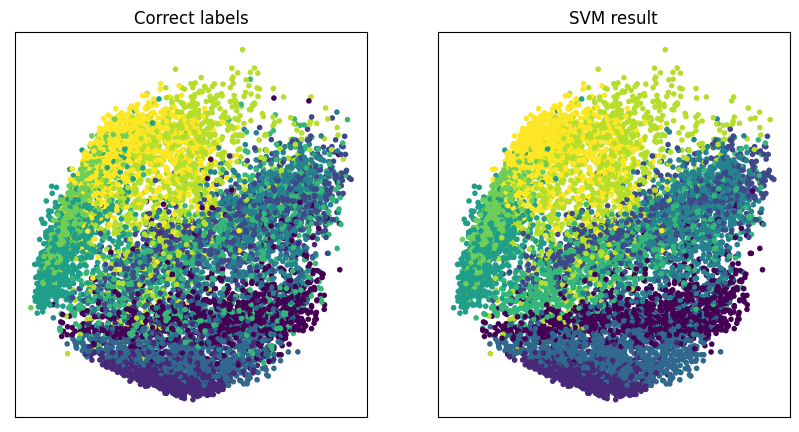

In [15]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].scatter(x_test_pc2[:,0], x_test_pc2[:,1], c=y_test, marker='.')
axs[0].set_title("Correct labels")
axs[1].scatter(x_test_pc2[:,0], x_test_pc2[:,1], c=y_pred, marker='.')
axs[1].set_title("SVM result")
for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])
plt.show()

Was die einzelnen Datenpunkte bedeuten, können wir auch visualisieren:

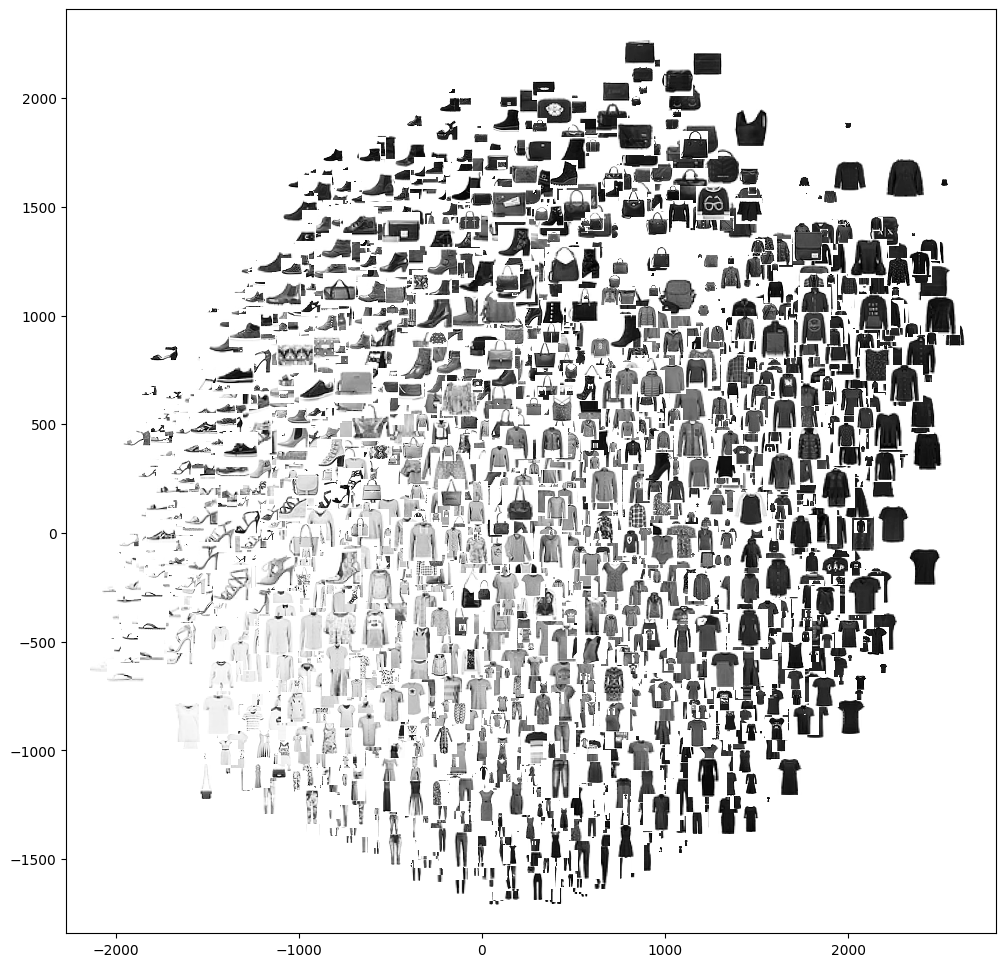

In [16]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

def imscatter(x, y, image, ax, zoom=1):
    im = OffsetImage(image, zoom=zoom, norm=plt.Normalize(0,255), cmap="Greys")
    x, y = np.atleast_1d(x, y)
    artists = []
    for x0, y0 in zip(x, y):
        ab = AnnotationBbox(im, (x0, y0), xycoords='data', frameon=False)
        artists.append(ax.add_artist(ab))
    ax.update_datalim(np.column_stack([x, y]))
    ax.autoscale()
    return artists

fig, ax = plt.subplots(figsize=(12,12))
# plot every 2nd:
for i in range(0, len(x_test_pc2), 2):
    imscatter(x_test_pc2[i,0], x_test_pc2[i,1], x_test[i].reshape(28,28), ax, zoom=np.random.rand())
plt.show()

Jetzt führen wir die Gittersuche durch, um gute Werte für die Hyperparameter $C, \gamma$ zu finden:

In [17]:
from sklearn.model_selection import train_test_split

def probe_intervals(x_train, y_train, gamma_a, gamma_b, C_a, C_b, trainsize=100, dims=6):
    param_grid = {
        "gamma": np.linspace(gamma_a, gamma_b, num=20),
        "C": np.linspace(C_a, C_b, num=20),
    }
    small_x, _, small_y, _ = train_test_split(x_train_pc, y_train,
                                              train_size=trainsize,
                                              random_state=23)
    grid_search = GridSearchCV(svc, param_grid=param_grid,
                               scoring='f1_macro')
    grid_search.fit(small_x[:,:dims], small_y)
    return grid_search.best_params_, grid_search.best_score_

In [18]:
probe_intervals(x_train_pc, y_train,
                1e-10, 1e-07,
                10, 300,
                trainsize=400, dims=6)

({'C': 208.42105263157896, 'gamma': 5.2678947368421055e-08},
 0.7330239234449761)

Sieht so aus als könnten gute Werte in der Nähe von 5e-08, 208 liegen.

In [19]:
probe_intervals(x_train_pc, y_train,
                1e-9, 1e-08,
                100, 250,
                trainsize=500, dims=8)

({'C': 147.36842105263156, 'gamma': 4.31578947368421e-09}, 0.7290049564834192)

Jetzt scheint es, als kämen doch auch weitere Werte in Frage ...

In [20]:
probe_intervals(x_train_pc, y_train,
                1e-10, 1e-07,
                50, 200,
                trainsize=600, dims=10)

({'C': 136.8421052631579, 'gamma': 2.1131578947368422e-08}, 0.7611363464719944)

Die optimalen Parameter hängen von der Anzahl betrachteter Dimensionen ab.

In [21]:
probe_intervals(x_train_pc, y_train,
                1e-9, 1e-08,
                50, 200,
                trainsize=600, dims=12)

({'C': 160.5263157894737, 'gamma': 8.105263157894737e-09}, 0.7560452746239141)

In [22]:
probe_intervals(x_train_pc, y_train,
                1e-9, 1e-08,
                50, 200,
                trainsize=1000, dims=12)

({'C': 176.31578947368422, 'gamma': 9.052631578947368e-09}, 0.7810231282387337)

Mit diesen Parametern ($dim=12, C=176, \gamma= 9*10^{-9}$) trainieren wir jetzt auf allen Samples:

In [23]:
from sklearn.metrics import f1_score

svc = SVC(C=176.3, gamma=9.05e-9).fit(x_train_pc[:,:12], y_train)
y_pred = svc.predict(x_test_pc[:,:12])
print(f1_score(y_test, y_pred, average="macro"))

0.8172201391692682


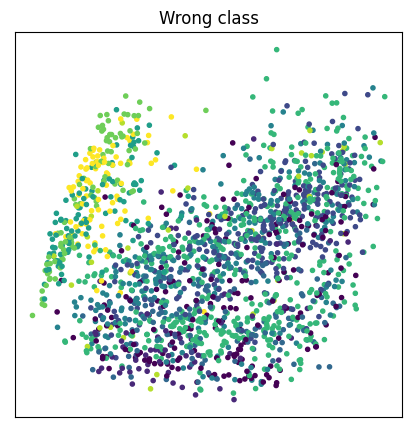

In [24]:
y_wrong_indices = (y_test != y_pred)
y_wrong = y_test[y_wrong_indices]
x_wrong = x_test_pc2[y_wrong_indices]

fig, ax = plt.subplots(figsize=(5, 5))
ax.scatter(x_wrong[:,0], x_wrong[:,1], c=y_wrong, marker='.')
ax.set_title("Wrong class")
ax.set_xticks([])
ax.set_yticks([])
plt.show()

Schaffen Sie eine bessere Klassifikation (mit F1-Score $> 82$)?